In [8]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [9]:
import sys
sys.path.append('..')

from bert.go import Ontology

In [10]:
ont = Ontology()

In [11]:
swissprot_dir = '/gpfs/alpine/bie108/proj-shared/swissprot/'
swissprot = pd.read_parquet(os.path.join(swissprot_dir, 'parsed_swissprot_uniref_clusters.parquet'))
go_terms = pd.read_parquet(os.path.join(swissprot_dir, 'swissprot_quickgo.parquet'))

swissprot_annotated = swissprot[swissprot.accession.isin(go_terms['GENE PRODUCT ID'].unique())]
swissprot_annotated = swissprot_annotated[swissprot_annotated.length < 10000]

In [12]:
len(go_terms['GO TERM'].unique())

28687

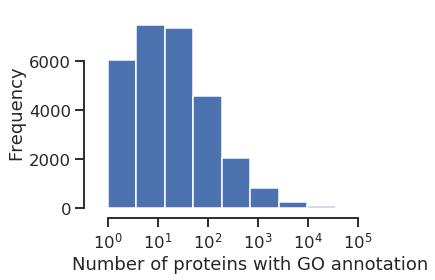

In [13]:
counts = go_terms['GO TERM'].value_counts()
np.log10(counts).plot.hist()
plt.xticks(ticks=np.arange(0, 6), labels=[f'$10^{i}$' for i in np.arange(0, 6)])
plt.xlabel('Number of proteins with GO annotation')
sns.despine(trim=True, offset=10)
plt.tight_layout()

In [14]:
head_nodes = {ont.G.nodes[ont.term_index[index]]['name']: index for index in ont.get_head_node_indices()}
head_nodes

{'biological_process': 6,
 'molecular_function': 3689,
 'cellular_component': 5261}

In [15]:
saved = np.load('/ccs/home/pstjohn/member_work/valid_pr.258061.npz')

precision_bp  = saved['precision_bp']
recall_bp     = saved['recall_bp']
thresholds_bp = saved['thresholds_bp']
precision_mf  = saved['precision_mf']
recall_mf     = saved['recall_mf']
thresholds_mf = saved['thresholds_mf']
precision_cc  = saved['precision_cc']
recall_cc     = saved['recall_cc']
thresholds_cc = saved['thresholds_cc']

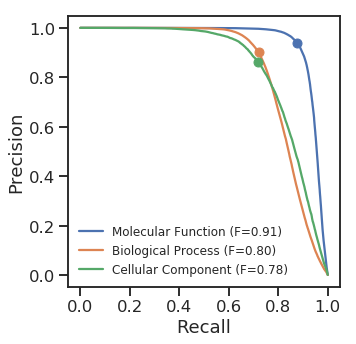

In [16]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, aspect='equal')


def get_fmax(precision, recall):
    fscores = (2 * precision * recall / (precision + recall))
    fmax = fscores.max()
    argmax = fscores.argmax()
    return fmax, argmax

fmax, argmax = get_fmax(precision_mf, recall_mf)
ax.plot(recall_mf, precision_mf, label=f'Molecular Function (F={fmax:.2f})', color=sns.color_palette()[0])
ax.plot(recall_mf[argmax], precision_mf[argmax], 'o', color=sns.color_palette()[0])

fmax, argmax = get_fmax(precision_bp, recall_bp)
ax.plot(recall_bp, precision_bp, label=f'Biological Process (F={fmax:.2f})', color=sns.color_palette()[1])
ax.plot(recall_bp[argmax], precision_bp[argmax], 'o', color=sns.color_palette()[1])

fmax, argmax = get_fmax(precision_cc, recall_cc)
ax.plot(recall_cc, precision_cc, label=f'Cellular Component (F={fmax:.2f})', color=sns.color_palette()[2])
ax.plot(recall_cc[argmax], precision_cc[argmax], 'o', color=sns.color_palette()[2])



ax.set_xticks(np.linspace(0, 1, 6, endpoint=True))
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
plt.legend(loc='lower left', fontsize=12)

In [6]:
import networkx as nx
import tensorflow as tf

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
gpu_index = 1

print("Num GPUs Available: ", len(gpu_devices))
tf.config.set_visible_devices(gpu_devices[gpu_index], 'GPU')
tf.config.experimental.set_memory_growth(gpu_devices[gpu_index], True)

from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

Num GPUs Available:  4


In [7]:
from run_validation import go_model_sigmoid, encode

In [8]:
def predict(protein_seq, max_len=2048):
    return go_model_sigmoid(tf.expand_dims(encode(protein_seq, max_len), 0))

In [54]:
def get_prediction_tree(sequence):

    prediction = predict(sequence)

    BP = ont.G.subgraph(ont.get_descendants('GO:0008150'))
    MF = ont.G.subgraph(ont.get_descendants('GO:0003674'))
    CC = ont.G.subgraph(ont.get_descendants('GO:0005575'))

    BP_sub = BP.subgraph(ont.array_to_termlist(prediction > 0.5))
    MF_sub = MF.subgraph(ont.array_to_termlist(prediction > 0.5))
    CC_sub = CC.subgraph(ont.array_to_termlist(prediction > 0.5))

    data = {}
    data['BP'] = nx.tree_data(BP_sub.edge_subgraph(nx.algorithms.minimum_spanning_arborescence(BP_sub).edges()), 'GO:0008150')
    data['MF'] = nx.tree_data(MF_sub.edge_subgraph(nx.algorithms.minimum_spanning_arborescence(MF_sub).edges()), 'GO:0003674')
    data['CC'] = nx.tree_data(CC_sub.edge_subgraph(nx.algorithms.minimum_spanning_arborescence(CC_sub).edges()), 'GO:0005575')
    
    return data

In [42]:
from jinja2 import Environment, FileSystemLoader

# Initialize the jinja templates
env = Environment(loader=FileSystemLoader('.'))

In [69]:
split = np.load('uniref50_split.npz', allow_pickle=True)
swissprot_valid = swissprot_annotated[swissprot_annotated['UniRef50 ID'].isin(split['valid'])]

In [78]:
row = swissprot_valid[swissprot_valid['NCBI Taxonomy'] == '3702'].iloc[2]

In [79]:
row

UniRef100 ID                                                UniRef100_F4IAT2
UniRef90 ID                                                  UniRef90_F4IAT2
UniRef50 ID                                                  UniRef50_F4IAT2
accession                                                             F4IAT2
EMBL                                                                AK227201
RefSeq                                                        NP_001185086.1
KEGG                                                           ath:AT1G24706
InterPro                                                           IPR032302
Pfam                                                                 PF16134
NCBI Taxonomy                                                           3702
length                                                                  1823
sequence                   MSLPLLECKYVTEEFVREGKNGNYGTKLPSSVPMLRFLYELSWILV...
subcellularLocalization                                              Nucleus

In [80]:
with open(f'output_trees/{row.accession}.html', 'w', encoding="utf-8") as f:
    f.write(env.get_template('tree_template.html').render(data=get_prediction_tree(row.sequence)))